In [99]:
# Import the necessary libraries
from qiskit import QuantumCircuit, transpile, Aer, execute
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
from qiskit.quantum_info import DensityMatrix
import torch


In [100]:
def initialize_all_zeros(nr_qubits):
    # Create a quantum circuit with N qubits
    qc = QuantumCircuit(nr_qubits)
    
    # Initialize all qubits in the |0⟩ state
    for qubit in range(nr_qubits):
        qc.initialize([1, 0], qubit)
    
    return qc

def apply_cnot_chain(qc, control_qubit, nr_qubits):
    # Apply CNOT gates from the control qubit to the list of target qubits
    for target_qubit in range(nr_qubits-1):
        qc.cx(control_qubit, target_qubit+1)

# def random_measurement_basis(nr_qubits): #applied to 1 qubit
#     measurement_basis = [1, 2, 3]
#     return [random.choice(measurement_basis) for _ in range(nr_qubits)]

# def measurement_bases_N(nr_qubits): #instantly works for all nr_qubits
#     # Generate 4 random numbers from the set {1, 2, 3}
#     random_bases = [random.choice([1, 2, 3]) for _ in range(nr_qubits)]
#     random_array = np.array(random_bases)
#     return [random_array]

def measurement_bases_N(nr_qubits):
    # Generate nr_qubits random numbers from the set {x=1, y=2, z=3}
    random_bases = np.random.choice([1, 2, 3], size=nr_qubits)
    return random_bases


In [101]:
nr_qubits = 4
control_qubit = 0 #Usually just the first qubit

n_sample = 2 #amount of times the shadows are generated and measured with 1 shot each



In [102]:
# Create an empty DataFrame with columns for measurement basis and result
# df = pd.DataFrame(columns=["Measurement Basis", "Measured Result"])

# Initialize a list to store the rows
rows = []

# Initialize an empty list to store the measured result and bases in the correct format for the AI model
measurement_results_in_specific_format = np.zeros((n_sample,nr_qubits), dtype=int)
measurement_bases_in_specific_format = []

for _ in range(n_sample):
    # Create a quantum circuit with N qubits
    qc = initialize_all_zeros(nr_qubits)

    # Apply a Hadamard gate to qubit 0
    qc.h(control_qubit)

    apply_cnot_chain(qc, control_qubit, nr_qubits)

    # Choose random measurement basis for each qubit
    measurement_bases = measurement_bases_N(nr_qubits)

    # Store the measurement bases in the list    
    measurement_bases_in_specific_format.append(measurement_bases)
    

    # Apply the measurement bases to the qubits
    for qubit in range(nr_qubits):
        if measurement_bases[qubit] == 1:
            qc.h(qubit)
        elif measurement_bases[qubit] == 2:
            qc.sdg(qubit)
            qc.h(qubit)

    # Add measurements for all qubits in the Z basis
    qc.measure_all()
    
    # Simulate the circuit and get measurement results
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=1)
    result = job.result()
    counts = result.get_counts(qc)

    # Iterate through the qubits and add their measurement results to the list
    for qubit in range(nr_qubits):
        basis = measurement_bases[qubit]
        result = int(list(counts.keys())[0][nr_qubits - 1 - qubit])  # Extract the result
        rows.append(pd.DataFrame({"Measurement Basis": [basis], "Measured Result": [result]}))
        
        measurement_results_in_specific_format[_][qubit] = result

    # Concatenate the rows into the DataFrame and reset the index
    df = pd.concat(rows, ignore_index=True)

    

# Display the DataFrame
print('df',df)

obs_before_tensor = measurement_bases_in_specific_format
print('obs_before_tensor', obs_before_tensor)

out_before_tensor = [np.array(row) for row in measurement_results_in_specific_format]
print('out_before_tensor', out_before_tensor)



df    Measurement Basis  Measured Result
0                  2                1
1                  2                0
2                  1                0
3                  3                0
4                  2                0
5                  3                0
6                  1                1
7                  2                1
obs_before_tensor [array([2, 2, 1, 3]), array([2, 3, 1, 2])]
out_before_tensor [array([1, 0, 0, 0]), array([0, 0, 1, 1])]


In [6]:
# print(measurement_bases)

tok = measurement_bases_N(nr_qubits)
print('tok', tok)

print(tok[0])

tok [1 1 1 3]
1


In [ ]:
# X=1 Y=2 Z=3


measurement_bases_in_specific_format = []
out = []


In [ ]:
measurement_bases_in_specific_format = []
out = []
for _ in range(n_sample):
    sigma = qst.random_pauli_state(n_qubit)
    bit = rho.copy().measure(sigma)[0]
    tok = sigma.tokenize()
    measurement_bases_in_specific_format.append(tok[:n_qubit,:n_qubit].diagonal())
    out.append((tok[:,-1]+bit)%2)
    print('tok[:n_qubit,:n_qubit].diagonal()',tok[:n_qubit,:n_qubit].diagonal())
    print('tok[:,-1]+bit)%2',(tok[:,-1]+bit)%2)
measurement_bases_in_specific_format = torch.tensor(numpy.stack(measurement_bases_in_specific_format))
out = torch.tensor(numpy.stack(out))

print('obs', measurement_bases_in_specific_format)
print('out', out)
print('shadow', Shadow(measurement_bases_in_specific_format, out))
return Shadow(measurement_bases_in_specific_format, out)

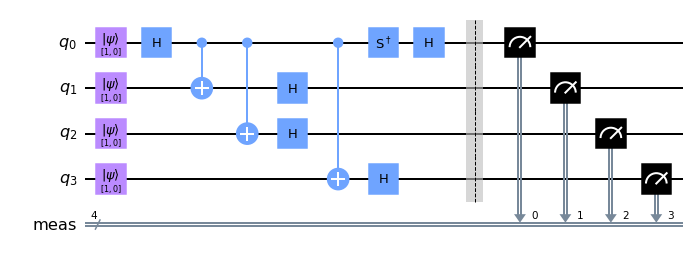

In [29]:
qc.draw(output='mpl')


In [69]:
# Initialize an empty list to store the arrays
measured_result_array = []

# Iterate through the measurements
for i in range(n_sample):
    # Initialize an array of zeros for each measurement
    result_array = np.zeros(nr_qubits, dtype=int)
    
    # Filter the DataFrame for the current measurement
    measurement_df = df[df.index % n_sample == i]
    
    # Fill in the results in the array based on the measurement basis
    for index, row in measurement_df.iterrows():
        basis = row["Measurement Basis"]
        result = row["Measured Result"]
        result_array[basis - 1] = result  # Subtract 1 as basis is 1-indexed
    
    # Append the array to the result_arrays list
    measured_result_array.append(result_array)

# result_arrays now contains the desired format
print(measured_result_array)

[array([0, 0, 1, 0]), array([0, 1, 1, 0])]


In [87]:
hardcoded_array = [np.array([0, 0, 1, 0]), np.array([0, 1, 1, 0])]
hardcoded_array[0][1]


AttributeError: 'list' object has no attribute 'shape'